Импорт библиотек

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st

import seaborn as sns 
import matplotlib.pyplot as plt 

sns.set(rc={'figure.figsize':(12,6)}, style='whitegrid')

Подгружаю данные, смотрю на тип данных, проверяю наличие пропущенных значений

In [6]:
df = pd.read_csv('london.csv', parse_dates=['timestamp'])

In [7]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [8]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [9]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

## 1. Строю график lineplot, чтобы посмотреть на распределение числа поездок (cnt) во времени(по оси x – дата (timestamp), по оси y – число поездок (cnt))

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

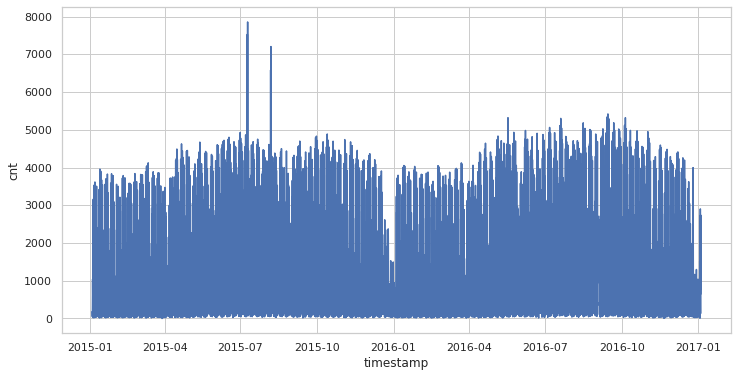

In [10]:
sns.lineplot(x=df.timestamp, y=df.cnt)

#### Ответ: 
Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

## 2.Использую агрегацию числа поездок по дням, и затем визуализирую полученный результат.

In [11]:
# сортирую значения в колонке timestamp с помощью метода sort_values
df.sort_values(by='timestamp', inplace=True)

# устанавливаю timestamp в качестве индекса, т.к resmaple() работает только с индексами
df.set_index('timestamp', drop=False, inplace=True)

In [12]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


<AxesSubplot:xlabel='timestamp'>

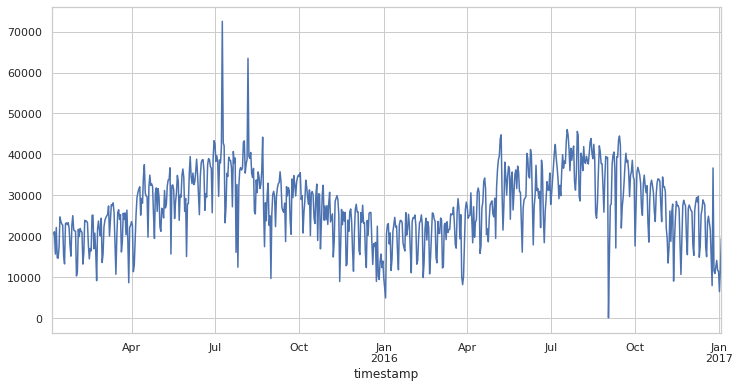

In [13]:
# агригирую количество аренд велосипедов по дням с помощью метода resample()

df.resample(rule='D').cnt.sum().plot()

#### Выводы:
- Максимальное число аренд за день составляет более 70 000
- Зимой число аренд меньше, чем летом
- Встречаются как очень резкие скачки числа аренд, так и падения

## 3.Считаю скользящее среднее на агрегированных данных по дням, чтобы сгладить ряд.

In [14]:
# агрегирую количество аренд по дням, присваю это переменной df_by_day

df_by_day = df.resample(rule='D').cnt.sum().reset_index()

In [15]:
df_by_day.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


Скользящее среднее

In [16]:
df_by_day_roll = df.resample(rule='D').cnt.sum().rolling(window=3).mean().reset_index()
df_by_day_roll

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667
...,...,...
726,2016-12-30,12682.000000
727,2016-12-31,12347.333333
728,2017-01-01,9803.666667
729,2017-01-02,9889.333333


## 4. Считаю разницу между наблюдаемыми и сглаженными значениями. Считаю стандратное отклонение.Определяю верхние и нижние границы 99% доверительного интервала. 

Разница между наблюдаемыми и сглаженными значениями. Стандратное отклонение.

In [18]:
df_daybday_std=round((np.std(df_by_day['cnt'] - df_by_day_roll['cnt'])),2)
df_daybday_std

4558.59

Верхняя граница 99% доверительного интервала

In [21]:
upper_bound = df_by_day_roll.cnt + (2.576 * df_daybday_std)
df_by_day['upper_bound'] = upper_bound

Нижняя граница 99% доверительного интервала

In [22]:
lower_bound = df_by_day_roll.cnt - (2.576 * df_daybday_std)
df_by_day['lower_bound'] = lower_bound

Вывел наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала

In [23]:
df_by_day[df_by_day.cnt > df_by_day.upper_bound]

,timestamp,cnt,upper_bound,lower_bound
186,2015-07-09,72504,62447.927840,38962.072160
214,2015-08-06,63468,58370.261173,34884.405493
609,2016-09-04,27512,26001.927840,2516.072160
721,2016-12-25,36653,31393.594507,7907.738827


#### Наибольшее число аренд отмечено 2015-07-09. C помощью Google можно выяснить, что в этот день в Лондоне была забастовка в метро, что, вероятно, послужило причиной высокого спроса на аренду велосипедов в этот день.

Вывел наблюдения, для которых наблюдаемые значения оказались ниже нижней границы 99% доверительного интервала

In [24]:
df_by_day[df_by_day.cnt < df_by_day.lower_bound]

,timestamp,cnt,upper_bound,lower_bound
130,2015-05-14,15609,40452.261173,16966.405493
189,2015-07-12,23240,47779.594507,24293.738827
201,2015-07-24,16034,42756.594507,19270.738827
232,2015-08-24,17400,41272.261173,17786.405493
314,2015-11-14,8898,32780.261173,9294.405493
607,2016-09-02,0,37829.261173,14343.405493
615,2016-09-10,17080,43004.927840,19519.072160
621,2016-09-16,21967,47936.261173,24450.405493
678,2016-11-12,8990,32620.927840,9135.072160


#### На собранных данных видно, что 2016-09-02 число аренд равно 0. Чтобы разобраться в чем причина такого падаения, я проверил данные в исходном датафрейме с 1 по 3 сентярбря 2016.

In [62]:
df['2016-09-01':'2016-09-03']

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,,
2016-09-01 00:00:00,2016-09-01 00:00:00,322,18.0,18.0,68.0,15.0,1.0,0.0,0.0,2.0
2016-09-01 01:00:00,2016-09-01 01:00:00,186,17.0,17.0,73.0,16.0,1.0,0.0,0.0,2.0
2016-09-01 02:00:00,2016-09-01 02:00:00,89,16.5,16.5,75.0,16.0,1.0,0.0,0.0,2.0
2016-09-01 03:00:00,2016-09-01 03:00:00,56,16.0,16.0,74.5,11.0,2.0,0.0,0.0,2.0
2016-09-01 04:00:00,2016-09-01 04:00:00,64,16.0,16.0,77.0,12.0,2.0,0.0,0.0,2.0
2016-09-01 05:00:00,2016-09-01 05:00:00,133,15.0,15.0,82.0,11.0,2.0,0.0,0.0,2.0
2016-09-01 06:00:00,2016-09-01 06:00:00,811,15.0,15.0,82.0,12.0,2.0,0.0,0.0,2.0
2016-09-01 07:00:00,2016-09-01 07:00:00,2663,16.0,16.0,77.0,11.0,2.0,0.0,0.0,2.0
2016-09-01 08:00:00,2016-09-01 08:00:00,4631,16.5,16.5,75.0,9.0,2.0,0.0,0.0,2.0


#### Можно обратить внимание на то, что данные за 2 сентября отсутствуют в датасете, вероятно, из-за какой-то ошибка данные за 2 сентября не логировались. 